# A simple Lattice Bolzmann scheme in 2D square region

LBM direction (ref: http://sites.psu.edu/sihongyan/pflbm/):

    6 2 5
    3 0 1
    7 4 8

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numba import jit

## Initialization

In [82]:
# == constants ==
nx = 200  # points in x direction
ny = 60  # points in y direction
nq = 9  # D2Q9 LBM
omega = 1 # relaxation parameters, between [0, 2]
force = 1e-10  # external forcing in x direction

cs2 = 1/3  # sound speed squared
cs = np.sqrt(cs2)  # sound speed
cs4 = cs2**2

# BC
wx = 30
lx = 50
wyh = int(ny - (ny - wx)/2);
wyl = int((ny - wx)/2);
b_left = int((nx - lx)/2); # 74
b_right = int((nx - lx)/2 + lx); #124

#  weights for D2Q9
w = np.array([4/9,
     1/9 ,1/9, 1/9, 1/9,
     1/36, 1/36, 1/36, 1/36])

# == prognostic variables ==
# Is (ny, nx, nq) a more efficient memory layout than (nq, ny, nx) ?
# +2 is for buffering regions
f = np.zeros((ny+2, nx+2, nq))  # particle population. 
feq = np.zeros((ny+2, nx+2, nq))  # The equilibrium distribution

ux = np.zeros((ny+2, nx+2))  #  macroscopic velocity in x
uy = np.zeros((ny+2, nx+2))  #  macroscopic velocity in y
rho = np.zeros((ny+2, nx+2))  # macroscopic density (sum of particle in all directions)

## The LBM solver code
Functions are written in C-like form. Only manipulating pointers. Do not return. Use loop insteads of vectorization.

In [83]:
@jit
def apply_forcing(f, force):
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    continue
            f[j, i, 1] += force
            f[j, i, 5] += force
            f[j, i, 8] += force

            f[j, i, 3] -= force
            f[j, i, 6] -= force
            f[j, i, 7] -= force

In [84]:
@jit
def equilibrium(rho, ux, uy, feq):   
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    feq[j,i,1] = 0.0
                    feq[j,i,2] = 0.0
                    feq[j,i,3] = 0.0
                    feq[j,i,4] = 0.0
                    continue
            # == expressions that can be reused ==  
            # Comments are the corresponding variable names in Sauro Succi's Fortran code
            ux_d_cs2 = ux[j, i] / cs2  # ui
            uy_d_cs2 = uy[j, i] / cs2  # vi
            ux2_d_2cs4 = ux[j, i]**2 / (2*cs4)  # u2
            uy2_d_2cs4 = uy[j, i]**2 / (2*cs4)  # v2
            
            v2_d_2cs2 = (ux[j, i]**2 + uy[j, i]**2) / (2*cs2)  # sumsq (v = velocity magnitude)
            v2_d_sp = v2_d_2cs2 * (1.0 - cs2) / cs2  # sumsq2  (sp = special)
            uxuy_d_cs4 = ux_d_cs2 * uy_d_cs2  # uv
        
            # == computing equilibrium ==
            feq[j, i, 0] = rho[j, i]*w[0]*(1 - v2_d_2cs2)

            feq[j, i, 1] = rho[j, i]*w[1]*(1 - v2_d_2cs2 + ux_d_cs2 + ux2_d_2cs4)
            feq[j, i, 2] = rho[j, i]*w[2]*(1 - v2_d_2cs2 + uy_d_cs2 + uy2_d_2cs4)
            feq[j, i, 3] = rho[j, i]*w[3]*(1 - v2_d_2cs2 - ux_d_cs2 + ux2_d_2cs4)
            feq[j, i, 4] = rho[j, i]*w[4]*(1 - v2_d_2cs2 - uy_d_cs2 + uy2_d_2cs4)

            feq[j, i, 5] = rho[j, i]*w[5]*(1 + v2_d_sp + ux_d_cs2 + uy_d_cs2 + uxuy_d_cs4)
            feq[j, i, 6] = rho[j, i]*w[6]*(1 + v2_d_sp - ux_d_cs2 + uy_d_cs2 - uxuy_d_cs4)
            feq[j, i, 7] = rho[j, i]*w[7]*(1 + v2_d_sp - ux_d_cs2 - uy_d_cs2 + uxuy_d_cs4)
            feq[j, i, 8] = rho[j, i]*w[8]*(1 + v2_d_sp + ux_d_cs2 - uy_d_cs2 - uxuy_d_cs4)

In [85]:
@jit
def collision(f, feq):
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    continue
            for q in range(nq):
                f[j, i, q] = (1.0 - omega)*f[j, i, q] + omega*feq[j, i, q]

In [86]:
@jit
def streaming(f):
    f_temp = f.copy()  # copy can be avoided with write-back strategy    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            # first-order neighbours
            f[j, i, 1] = f_temp[j, i-1, 1]
            f[j, i, 2] = f_temp[j-1, i, 2]
            f[j, i, 3] = f_temp[j, i+1, 3]
            f[j, i, 4] = f_temp[j+1, i, 4]
            
            # second-order neighbours
            f[j, i, 5] = f_temp[j-1, i-1, 5]
            f[j, i, 6] = f_temp[j-1, i+1, 6]
            f[j, i, 7] = f_temp[j+1, i+1, 7]
            f[j, i, 8] = f_temp[j+1, i-1, 8]

In [87]:
@jit
def macroscopic(f, rho, ux, uy):
    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    rho[j, i] = np.nan #1.0
                    ux[j, i] = np.nan #0.0
                    uy[j, i] = np.nan #0.0
                    continue
            rho[j, i] = f[j, i, :].sum()
            
                # unroll loop explictly to avoid summing over zeros
            ux[j, i] = (f[j, i, 1] + f[j, i, 5] + f[j, i, 8] 
                           - f[j, i, 3] - f[j, i, 6] - f[j, i, 7]
                          )/rho[j, i]

            uy[j, i] = (f[j, i, 2] + f[j, i, 5] + f[j, i, 6] 
                           - f[j, i, 4] - f[j, i, 7] - f[j, i, 8]
                          )/rho[j, i]
            

In [99]:
@jit
def BC0(f):
    # north wall, bounce-back
    for i in range(1, nx+1):
        f[ny+1, i, 4] = f[ny, i, 2]
        f[ny+1, i, 8] = f[ny, i+1, 6]
        f[ny+1, i, 7] = f[ny, i-1, 5]
        
    # south wall, bounce-back
    for i in range(1, nx+1):
        f[0, i, 2] = f[1, i, 4]
        f[0, i, 6] = f[1, i-1, 8]
        f[0, i, 5] = f[1, i+1, 7]
    
    # west interface, periodic
    for j in range(1, ny+1):
        f[j, 0, 1] = f[j, nx, 1]
        f[j, 0, 5] = f[j, nx, 5]
        f[j, 0, 8] = f[j, nx, 8]
    
    # east interface, periodic
    for j in range(1, ny+1):
        f[j, nx+1, 3] = f[j, 1, 3]
        f[j, nx+1, 6] = f[j, 1, 6]
        f[j, nx+1, 7] = f[j, 1, 7] 
    
    
    for j in range(b_left, b_right+1):
        # top
        f[wyh, j, 4] = f[wyh+1, j, 2]
        f[wyh, j, 8] = f[wyh+1, j-1, 6]
        f[wyh, j, 7] = f[wyh+1, j+1, 5]
        # bottom 
        f[wyl, j, 2] = f[wyl-1, j, 4]
        f[wyl, j, 5] = f[wyl-1, j-1, 7]
        f[wyl, j, 6] = f[wyl-1, j+1, 8]
        
    for i in range(2, wyl+1):
        # left
        f[i, b_left, 3] = f[i, b_left+1, 1]
        f[i, b_left, 7] = f[i+1, b_left+1, 5]
        f[i, b_left, 6] = f[i-1, b_left+1, 8]
        # right
        f[i, b_right, 1] = f[i, b_right-1, 3]
        f[i, b_right, 5] = f[i-1, b_right-1, 7]
        f[i, b_right, 8] = f[i+1, b_right-1, 6]
    
    for i in range(wyh, ny):
        # left
        f[i, b_left, 3] = f[i, b_left+1, 1]
        f[i, b_left, 7] = f[i+1, b_left+1, 5]
        f[i, b_left, 6] = f[i-1, b_left+1, 8]
        #right
        f[i, b_right, 1] = f[i, b_right-1, 3]
        f[i, b_right, 5] = f[i-1, b_right-1, 7]
        f[i, b_right, 8] = f[i+1, b_right-1, 6]
        
#     # square corners
#     # top square
#     f[ny, b_left, 7] = f[ny+1, b_left+1, 5] # north-west
#     f[ny, b_right, 8] = f[ny+1, b_right-1, 6] # north-east
#     f[wyh, b_right, 8] = f[wyh+1, b_right-1, 6] # south-west
#     f[wyh, b_left, 7] = f[wyh+1, b_left+1, 5] # south-east
#     # bottom square
#     f[wyl, b_left, 6] = f[wyl-1, b_left+1, 8]
#     f[wyl, b_right, 5] = f[wyh-1, b_right-1, 7]   
#     f[0, b_left, 6] = f[1, b_left+1, 8]
#     f[0, b_right, 5] = f[1, b_right-1, 7]

    # 4 corners, bounce-back
    f[ny+1, 0, 8] = f[ny, 1, 6]  # north-west
    f[0, 0, 5] = f[1, 1, 7]  # south-west
    f[ny+1, nx+1, 7] = f[ny, nx, 5]  # north-east
    f[0, nx+1, 6] = f[1, nx, 8]  # south-east

In [89]:
@jit
def initialize(f, feq, rho, ux, uy):
    '''
    Output
    ------
    f: 3D numpy array, population
    feq: 3D numpy array, equilibrium population
    rho: 2D numpy array, density
    ux, uy: 2D numpy array, velocity
    '''
    
    # uniform density
    rho[:] = 1.0
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    rho[j,i] = 0.0
                    continue
    ux[:] = 0.0
    uy[:] = 0.0
    
    # use equilibrium as initial population
    equilibrium(rho, ux, uy, feq)
    f[:] = feq

@jit
def lbm_solver(f, rho, ux, uy, nt):
    
    initialize(f, feq, rho, ux, uy)
    
    for it in range(0, nt):
        BC0(f)
        streaming(f)
        macroscopic(f, rho, ux, uy)
        equilibrium(rho, ux, uy, feq)
        collision(f, feq)
        apply_forcing(f, force)

# Run solver

In [100]:
%time lbm_solver(f, rho, ux, uy, 100000)

CPU times: user 1min 26s, sys: 931 ms, total: 1min 27s
Wall time: 1min 27s


# Sanity check

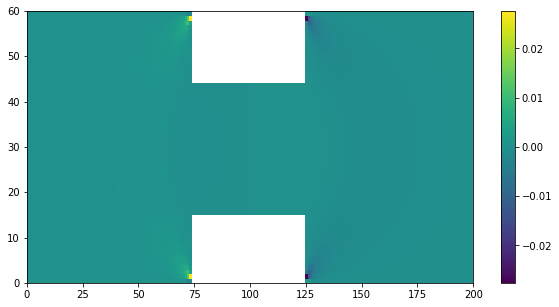

In [97]:
plt.figure(figsize=(10,5))
plt.pcolormesh(ux[1:-1,1:-1])
plt.colorbar()
plt.show()

In [98]:
# REYNOLDS NUMBER:
print(np.mean(ux[1:-1,1])*(10))

0.0001309811578135817


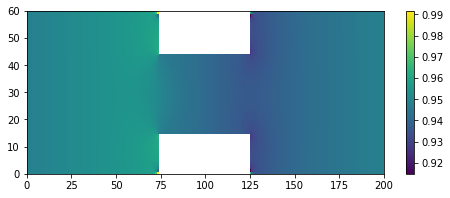

In [12]:
plt.figure(figsize=(8,3))
plt.pcolormesh(rho[1:-1,1:-1])
plt.colorbar()

# Post-processing

In [13]:
# xarray's mean() and sum() automatically skip nan. Very convenient for later calculations.

import xarray as xr

# coordinate for xarray
coords={'x': np.arange(1, nx+1, dtype=float), 'y': np.arange(1, ny+1, dtype=float)}

dr_ux = xr.DataArray(ux[1:-1, 1:-1], dims=('y', 'x'), coords=coords)
dr_uy = xr.DataArray(uy[1:-1, 1:-1], dims=('y', 'x'), coords=coords)
dr_rho = xr.DataArray(rho[1:-1, 1:-1], dims=('y', 'x'), coords=coords)
dr_p = dr_rho / 6  # pressure field 


# Formal plotting

Text(0.5,1,'velocity $u_x$')

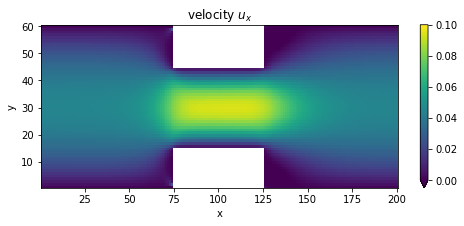

In [14]:
fig, ax = plt.subplots(1, 1, figsize=[8, 3])
dr_ux.plot(vmin=0, vmax=0.1, ax=ax)
plt.title('velocity $u_x$')

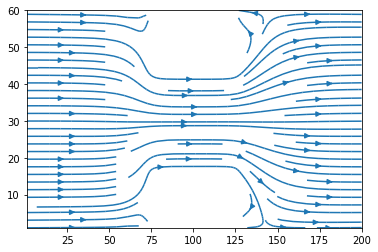

In [15]:
plt.streamplot(coords['x'], coords['y'], dr_ux, dr_uy)

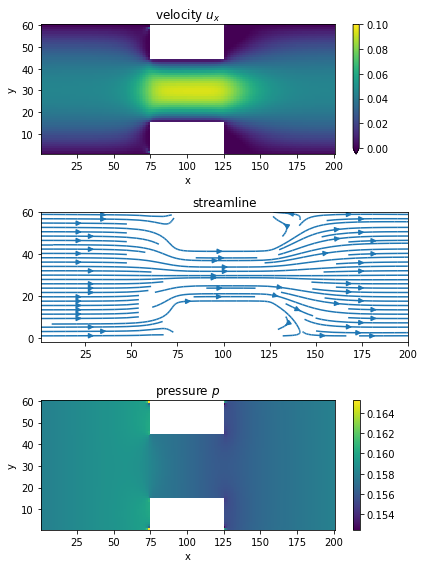

In [16]:
# put together
fig, axes = plt.subplots(3, 1, figsize=[6, 8])

dr_ux.plot(vmin=0, vmax=0.1, ax=axes[0])
axes[0].set_title('velocity $u_x$')

axes[1].streamplot(coords['x'], coords['y'], dr_ux, dr_uy)
axes[1].set_title('streamline')

dr_p.plot(ax=axes[2])
axes[2].set_title('pressure $p$')

fig.tight_layout()

# The volume flow rate

Text(0.5,1,'volume flow rate at different cross section')

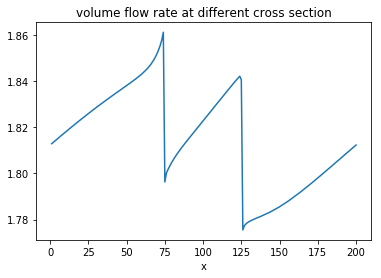

In [17]:
dr_ux.sum(dim='y').plot()  # roughly constant
plt.title('volume flow rate at different cross section')

In [18]:
dr_ux.sum(dim='y').mean()  # get a single number

<xarray.DataArray ()>
array(1.815121)

## Volume flow rate with different width w

In [19]:
# TBD

# Bernoulli estimate

In [20]:
# At x=0
rho_0 = dr_rho.isel(x=0).mean().data
u_0 = dr_ux.isel(x=0).mean().data
p_0 = dr_p.isel(x=0).mean().data

In [21]:
0.5 * rho_0 * u_0**2, p_0

(0.0004328248457035917, array(0.15802586))

In [22]:
ber_0 = 0.5 * rho_0 * u_0**2 + p_0
ber_0

0.15845868675143154

In [23]:
# At the center of narrowing 
mid = nx//2

rho_i = dr_rho.isel(x=mid).mean().data
u_i = dr_ux.isel(x=mid).mean().data
p_i = dr_p.isel(x=mid).mean().data

In [24]:
0.5 * rho_i * u_i**2, p_i

(0.0018609245422420157, array(0.15685758))

In [25]:
ber_i = 0.5 * rho_i * u_i**2 + p_i
ber_i

0.15871850395147663

In [26]:
# the relative change in `ber` is much smaller than the change in pressuer
(ber_i - ber_0)/ber_0, (p_i - p_0)/p_0

(0.001639652614644302, -0.007392982910545938)

## Bernoulli estimate for all cross sections

In [27]:
rho_ym = dr_rho.mean(dim='y')
u_ym = dr_ux.mean(dim='y')
p_ym = dr_p.mean(dim='y')

In [28]:
ber = 0.5 * rho_ym * u_ym**2 +  p_ym

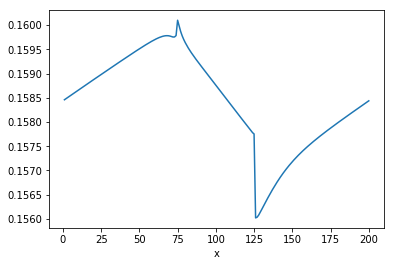

In [29]:
ber.plot()  # roughly constant